<a href="https://colab.research.google.com/github/liuyang1230/style_categorize_intern/blob/main/05_2_%E3%82%B9%E3%82%BF%E3%82%A4%E3%83%AB%E5%88%86%E9%A1%9E_data_aug_VGG16_size_cut_Adadelta_with_new_data_agumentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
# AnoGANに必要なモジュールを読込む
#from __future__ import print_function
from keras import backend as K
from keras import initializers
from keras.backend.tensorflow_backend import set_session
from keras.datasets import mnist
from keras.layers import Input, Reshape, Dense, Dropout, MaxPooling2D, Conv2D, Flatten
from keras.layers import Conv2DTranspose, LeakyReLU
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras.utils.generic_utils import Progbar
from keras.preprocessing.image import load_img, img_to_array,array_to_img
import keras.utils
from keras import utils as np_utils
from keras.utils import to_categorical

import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import os
import argparse
%matplotlib inline 
import glob
from PIL import Image


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
config = tf.ConfigProto(gpu_options=tf.GPUOptions(visible_device_list="7",allow_growth=True))
set_session(tf.Session(config=config))

In [ ]:
target_size_1=(420,280) #load
target_size_2 = (350,140) #test
#target_size_3 =(420,168)

In [ ]:
def size_cut(img):
    _,h,w,_ = img.shape
    center_h = h/2 
    center_w = w/2
    
    top = int(center_h  - h/2)
    bottom = int(center_h  + h/2)
    left = int(center_w - 3*w/10)
    right = int(center_w + 3*w/10)
    
    img = img[:,top:bottom, left:right, :]

    return img

In [ ]:
def size_change(img, target_size_test):
    IMG_dat = []
    for num in range(len(img)):
        npimg = img[num]
        npimg = cv2.resize(npimg,(target_size_test[1], target_size_test[0]))
        IMG_dat.append(npimg)
    IMG_dat = np.asarray(IMG_dat)
    IMG_dat =IMG_dat.astype(np.uint8)
    return IMG_dat

In [ ]:
def random_crop(img,crop_size,a):
    _,h,w,_ = img.shape
    np.random.seed(a)
    top = np.random.randint(0, h-crop_size[0])
    left = np.random.randint(0, w-crop_size[1])
    
    bottom = top + crop_size[0]
    right = left + crop_size[1]
    
    img = img[:,top:bottom, left:right, :]
    return img

In [ ]:
def random_erasing(img_origin,target_size_final, s =(0.04,0.3),r = (0.3,3)):
    img_origin= size_change(img_origin,target_size_final)
    #IMG_dat = []
    #print(img_origin.shape)
    for num in range(len(img_origin)):     
        mask_value = np.random.randint(0, 255)
        _,h,w,_ = img_origin.shape
            
        mask_area = np.random.randint(h*w*s[0], h*w*s[1])
        mask_aspect_ratio = np.random.rand() * r[1] + r[0]
        mask_height = int(np.sqrt(mask_area / mask_aspect_ratio))
        if mask_height > h - 1:
            mask_height = h - 1
        mask_width = int(mask_aspect_ratio * mask_height)
        if mask_width > w - 1:
            mask_width = w - 1

        top = np.random.randint(0, h - mask_height)
        left = np.random.randint(0, w - mask_width)
        bottom = top + mask_height
        right = left + mask_width
        #print(top,bottom, left,right, mask_value)
        img_origin[num,top:bottom, left:right, :].fill(mask_value)
        
        #IMG_dat.append(img)
    
    #IMG_dat = np.asarray(IMG_dat)
    return img_origin  

In [ ]:
def horizontal_flip (img,target_size_final):
    img= size_change(img,target_size_final)
    img = img[:,:,::-1,:]
    return img

In [ ]:
#教師データとテストデータの分類
def data_classification(jpg_list,target_size_load): 

    IMG_test_dat = []
    IMG_train_dat = []
    #画像のサイス切り取り
    IMG_dat = []
    for num in range(len(jpg_list)):
        img= load_img(jpg_list[num],target_size = target_size_load, interpolation='bilinear')
        npimg = img_to_array(img)
        IMG_dat.append(npimg)
    IMG_dat = np.asarray(IMG_dat)
    img_loaded = size_cut(IMG_dat)
    
    for num in range(len(img_loaded)):
        #kerasでファイルを読み込み
        npimg = img_loaded[num]
        if(num < 70) :
            #画像(配列変換隅)のデータセット一覧
            IMG_train_dat.append(npimg)
        else :
            #画像(配列変換隅)のデータセット一覧
            IMG_test_dat.append(npimg)
    IMG_train_dat = np.asarray(IMG_train_dat)
    IMG_test_dat = np.asarray(IMG_test_dat)
    
    IMG_train_dat = IMG_train_dat.astype(np.uint8)
    IMG_test_dat = IMG_test_dat.astype(np.uint8)
    return IMG_train_dat, IMG_test_dat

In [ ]:
#Ethnic類
os.chdir("/notebooks/note/image/Ethnic")

jpg_list = sorted(glob.glob('*.jpg'))

IMG_ETHNIC_train_dat,IMG_ETHNIC_test_dat= data_classification(jpg_list, target_size_1)  
#テストデータ
IMG_ETHNIC_test_dat=size_change(IMG_ETHNIC_test_dat, target_size_2)
#教師データの水増し
IMG_ETHNIC_train1 = random_crop(IMG_ETHNIC_train_dat[:70,:,:,:],target_size_2,1)
IMG_ETHNIC_train2 = random_crop(IMG_ETHNIC_train_dat[:70,:,:,:],target_size_2,2)
IMG_ETHNIC_train3 = random_crop(IMG_ETHNIC_train_dat[:70,:,:,:],target_size_2,3)
IMG_ETHNIC_train4 = random_crop(IMG_ETHNIC_train_dat[:70,:,:,:],target_size_2,4)
IMG_ETHNIC_train5 = random_crop(IMG_ETHNIC_train_dat[:70,:,:,:],target_size_2,5)#ここまではcrop
IMG_ETHNIC_train6= random_erasing(IMG_ETHNIC_train_dat[:70,:,:,:],target_size_2)
IMG_ETHNIC_train7= random_erasing(IMG_ETHNIC_train_dat[:70,:,:,:],target_size_2)
IMG_ETHNIC_train8= random_erasing(IMG_ETHNIC_train_dat[:70,:,:,:],target_size_2)
IMG_ETHNIC_train9= random_erasing(IMG_ETHNIC_train_dat[:70,:,:,:],target_size_2)
IMG_ETHNIC_train10= random_erasing(IMG_ETHNIC_train_dat[:70,:,:,:],target_size_2)#ここまではdata erasing
IMG_ETHNIC_train11= horizontal_flip (IMG_ETHNIC_train_dat[:70,:,:,:],target_size_2) #ここまではhorizontal flip

IMG_ETHNIC_train = np.vstack([IMG_ETHNIC_train1,IMG_ETHNIC_train2,IMG_ETHNIC_train3,IMG_ETHNIC_train4,IMG_ETHNIC_train5,
                             IMG_ETHNIC_train6,IMG_ETHNIC_train7,IMG_ETHNIC_train8,IMG_ETHNIC_train9,IMG_ETHNIC_train10,
                             IMG_ETHNIC_train11])
ethnic_label = np.array([0]*800)

In [ ]:
#IMG_ETHNIC_train.shape

In [ ]:
#plt.imshow(IMG_ETHNIC_train6[10])

In [ ]:
#plt.imshow(IMG_ETHNIC_train7[10])

In [ ]:
#plt.imshow(IMG_ETHNIC_train8[10])

In [ ]:
#plt.imshow(IMG_ETHNIC_train9[10])

In [ ]:
#plt.imshow(IMG_ETHNIC_train10[10])

In [ ]:
#plt.imshow(IMG_ETHNIC_train11[10])

In [ ]:
#plt.imshow(IMG_ETHNIC_train1[10])

In [ ]:
#plt.imshow(IMG_ETHNIC_train2[10])

In [ ]:
#plt.imshow(IMG_ETHNIC_train3[10])

In [ ]:
#plt.imshow(IMG_ETHNIC_train4[10])

In [ ]:
#plt.imshow(IMG_ETHNIC_train5[10])

In [ ]:
#Feminine類
os.chdir("/notebooks/note/image/Feminine")

jpg_list = sorted(glob.glob('*.jpg'))

IMG_FEMININE_train_dat,IMG_FEMININE_test_dat= data_classification(jpg_list, target_size_1)  
#テストデータ
IMG_FEMININE_test_dat=size_change(IMG_FEMININE_test_dat, target_size_2)
#教師データの水増し

IMG_FEMININE_train1 = random_crop(IMG_FEMININE_train_dat[:70,:,:,:],target_size_2,1)
IMG_FEMININE_train2 = random_crop(IMG_FEMININE_train_dat[:70,:,:,:],target_size_2,2)
IMG_FEMININE_train3 = random_crop(IMG_FEMININE_train_dat[:70,:,:,:],target_size_2,3)
IMG_FEMININE_train4 = random_crop(IMG_FEMININE_train_dat[:70,:,:,:],target_size_2,4)
IMG_FEMININE_train5 = random_crop(IMG_FEMININE_train_dat[:70,:,:,:],target_size_2,5)
IMG_FEMININE_train6= random_erasing(IMG_FEMININE_train_dat[:70,:,:,:],target_size_2)
IMG_FEMININE_train7= random_erasing(IMG_FEMININE_train_dat[:70,:,:,:],target_size_2)
IMG_FEMININE_train8= random_erasing(IMG_FEMININE_train_dat[:70,:,:,:],target_size_2)
IMG_FEMININE_train9= random_erasing(IMG_FEMININE_train_dat[:70,:,:,:],target_size_2)
IMG_FEMININE_train10= random_erasing(IMG_FEMININE_train_dat[:70,:,:,:],target_size_2)#ここまではdata erasing
IMG_FEMININE_train11= horizontal_flip (IMG_FEMININE_train_dat[:70,:,:,:],target_size_2) #ここまではhorizontal flip

IMG_FEMININE_train = np.vstack([IMG_FEMININE_train1,IMG_FEMININE_train2,IMG_FEMININE_train3,IMG_FEMININE_train4,IMG_FEMININE_train5,
                                IMG_FEMININE_train6,IMG_FEMININE_train7,IMG_FEMININE_train8,IMG_FEMININE_train9,IMG_FEMININE_train10,
                                IMG_FEMININE_train11])

feminine_label = np.array([1]*800)

In [ ]:
#Masculine類
os.chdir("/notebooks/note/image/Masculine")

jpg_list = sorted(glob.glob('*.jpg'))

IMG_MASCULINE_train_dat,IMG_MASCULINE_test_dat= data_classification(jpg_list, target_size_1)  
#テストデータ
IMG_MASCULINE_test_dat=size_change(IMG_MASCULINE_test_dat, target_size_2)
#教師データの水増し
IMG_MASCULINE_train1 = random_crop(IMG_MASCULINE_train_dat[:70,:,:,:],target_size_2,1)
IMG_MASCULINE_train2 = random_crop(IMG_MASCULINE_train_dat[:70,:,:,:],target_size_2,2)
IMG_MASCULINE_train3 = random_crop(IMG_MASCULINE_train_dat[:70,:,:,:],target_size_2,3)
IMG_MASCULINE_train4 = random_crop(IMG_MASCULINE_train_dat[:70,:,:,:],target_size_2,4)
IMG_MASCULINE_train5 = random_crop(IMG_MASCULINE_train_dat[:70,:,:,:],target_size_2,5)
IMG_MASCULINE_train6= random_erasing(IMG_MASCULINE_train_dat[:70,:,:,:],target_size_2)
IMG_MASCULINE_train7= random_erasing(IMG_MASCULINE_train_dat[:70,:,:,:],target_size_2)
IMG_MASCULINE_train8= random_erasing(IMG_MASCULINE_train_dat[:70,:,:,:],target_size_2)
IMG_MASCULINE_train9= random_erasing(IMG_MASCULINE_train_dat[:70,:,:,:],target_size_2)
IMG_MASCULINE_train10= random_erasing(IMG_MASCULINE_train_dat[:70,:,:,:],target_size_2)#ここまではdata erasing
IMG_MASCULINE_train11= horizontal_flip (IMG_MASCULINE_train_dat[:70,:,:,:],target_size_2) #ここまではhorizontal flip

IMG_MASCULINE_train = np.vstack([IMG_MASCULINE_train1,IMG_MASCULINE_train2,IMG_MASCULINE_train3,IMG_MASCULINE_train4,IMG_MASCULINE_train5,
                                 IMG_MASCULINE_train6,IMG_MASCULINE_train7,IMG_MASCULINE_train8,IMG_MASCULINE_train9,IMG_MASCULINE_train10,
                                 IMG_MASCULINE_train11])

masculine_label = np.array([2]*800)

In [ ]:
x_train=np.vstack([IMG_ETHNIC_train,IMG_FEMININE_train,IMG_MASCULINE_train])

In [ ]:
y_train_ethnic = ethnic_label[:770]
y_train_feminine = feminine_label[:770]
y_train_masculine = masculine_label[:770]

In [ ]:
y_test_ethnic = ethnic_label[770:]
y_test_feminine = feminine_label[770:]
y_test_masculine = masculine_label[770:]

In [ ]:
x_test=np.vstack([IMG_ETHNIC_test_dat,IMG_FEMININE_test_dat,IMG_MASCULINE_test_dat])

In [ ]:
y_train = np.concatenate([y_train_ethnic,y_train_feminine,y_train_masculine])
y_test = np.concatenate([y_test_ethnic,y_test_feminine,y_test_masculine])

In [ ]:
num_classes = 3
epochs = 20
batch_size = 10
input_shape = (target_size_2[0],target_size_2[1],3)

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# ラベルはone-hot encodingを施す
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test =  keras.utils.np_utils.to_categorical(y_test, num_classes)

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

input_tensor = Input(shape=(target_size_2[0],target_size_2[1], 3))
vgg16_model = VGG16(include_top=False, weights='imagenet', input_tensor = input_tensor)


In [ ]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 350, 140, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 350, 140, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 350, 140, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 175, 70, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 175, 70, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 175, 70, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 87, 35, 128)       0         
__________

In [ ]:
vgg16_out_shape = K.int_shape(vgg16_model.output)

In [ ]:
top_model = Sequential()
#top_model.add(Conv2D(32, kernel_size=(3, 3),
#                 activation='relu',
#                 input_shape=(4,3,512)))
#top_model.add(Conv2D(64, (3, 3), activation='relu',strides = 2))
#top_model.add(Conv2D(128, (3, 3), activation='relu',strides = 2))
#top_model.add(Conv2D(256, (3, 3), activation='relu',strides = 2))
#top_model.add(MaxPooling2D(pool_size=(2, 2)))
#top_model.add(Dropout(0.25))
top_model.add(Flatten(input_shape=vgg16_model.output_shape[1:]))
top_model.add(Dense(2048, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(128, activation='relu'))

top_model.add(Dense(3, activation='softmax'))
#モデルの評価
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 20480)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              41945088  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 42,207,747
Trainable params: 42,207,747
Non-trainable params: 0
_________________________________________________________________


In [ ]:
vgg16_model.input.shape

TensorShape([Dimension(None), Dimension(350), Dimension(140), Dimension(3)])

In [ ]:
vgg16_model.output.shape

TensorShape([Dimension(None), Dimension(10), Dimension(4), Dimension(512)])

In [ ]:
#top_model.add(Reshape(target_shape=(150, 100, 3),
#                      input_shape=list(top_model.output.get_shape().as_list()[1:])))
new_model = Model(inputs = vgg16_model.input, outputs = top_model(vgg16_model.output))
print('new model:', new_model)
new_model.summary()

new model: <keras.engine.training.Model object at 0x7fdcfc01acf8>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 350, 140, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 350, 140, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 350, 140, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 175, 70, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 175, 70, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 175, 70, 128)      147584    
_________________________________________________________________
block2_poo

In [ ]:
new_model.layers[3].name

'block1_pool'

In [ ]:
for i in range(len(new_model.layers)):
    print(i, new_model.layers[i].name)
    
for layer in new_model.layers[:19]:
    layer.trainable = False
    
new_model.summary()

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 sequential_1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 350, 140, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 350, 140, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 350, 140, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 175, 70, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 175,

In [ ]:
new_model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
#                  optimizer=keras.optimizers.Adam(lr=0.00001),
                  metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
#モデルの学習
history = new_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
          verbose=1, validation_data=(x_test, y_test),callbacks=[early_stopping])

#学習終了時の精度評価
score = new_model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 2310 samples, validate on 90 samples
Epoch 1/20
2310/2310 [==============================] - 21s 9ms/step - loss: 0.8174 - acc: 0.6957 - val_loss: 0.5226 - val_acc: 0.8111
Epoch 2/20
2310/2310 [==============================] - 19s 8ms/step - loss: 0.2664 - acc: 0.9087 - val_loss: 0.6981 - val_acc: 0.8000
Epoch 3/20
2310/2310 [==============================] - 19s 8ms/step - loss: 0.1378 - acc: 0.9468 - val_loss: 0.6061 - val_acc: 0.8000
Epoch 4/20
2310/2310 [==============================] - 19s 8ms/step - loss: 0.0746 - acc: 0.9719 - val_loss: 0.9840 - val_acc: 0.7556
Epoch 5/20
2310/2310 [==============================] - 19s 8ms/step - loss: 0.0368 - acc: 0.9857 - val_loss: 0.8708 - val_acc: 0.8111
Epoch 6/20
2310/2310 [==============================] - 19s 8ms/step - loss: 0.0389 - acc: 0.9874 - val_loss: 1.2314 - val_acc: 0.7556
Test loss: 1.2314161760939493
Test accuracy: 0.7555555476082696


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
sns.set()
y_predict_test_prob=new_model.predict(x_test)
y_predict_test=np.argmax(y_predict_test_prob,axis=1)
y_real_test=np.argmax(y_test,axis=1)

In [ ]:
y_predict_test_prob

array([[6.17143393e-01, 1.45033641e-09, 3.82856607e-01],
       [9.99808729e-01, 6.93197364e-07, 1.90572653e-04],
       [9.99629736e-01, 2.10904020e-07, 3.70056339e-04],
       [1.49645880e-02, 6.79047616e-07, 9.85034704e-01],
       [9.61440086e-01, 3.85258980e-02, 3.40845254e-05],
       [9.99821484e-01, 4.73644484e-08, 1.78564078e-04],
       [1.14005303e-03, 6.93854554e-06, 9.98852968e-01],
       [2.20019788e-01, 2.08938062e-07, 7.79980004e-01],
       [8.59643638e-01, 1.40346795e-01, 9.57830252e-06],
       [3.51372585e-02, 3.55136490e-06, 9.64859128e-01],
       [1.94006425e-04, 2.20141446e-04, 9.99585807e-01],
       [2.30157197e-01, 4.71679986e-01, 2.98162788e-01],
       [9.82853234e-01, 1.58827975e-02, 1.26399030e-03],
       [9.79344428e-01, 1.26835902e-03, 1.93872564e-02],
       [9.99999881e-01, 1.67166931e-07, 1.79629005e-08],
       [4.44457808e-04, 2.54732583e-07, 9.99555290e-01],
       [9.93236601e-01, 2.75381672e-06, 6.76064566e-03],
       [6.47590816e-01, 3.37041

Text(89.18,0.5,'true fashion style')

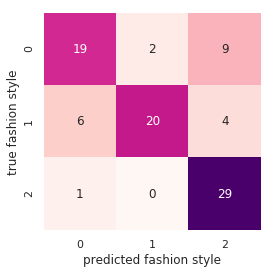

In [ ]:
mat_test = confusion_matrix(y_true=y_real_test, y_pred=y_predict_test,labels=[0,1,2])
sns.heatmap(mat_test, square = True, annot = True, cbar = False, cmap = 'RdPu')
plt.xlabel ('predicted fashion style')
plt.ylabel ('true fashion style')

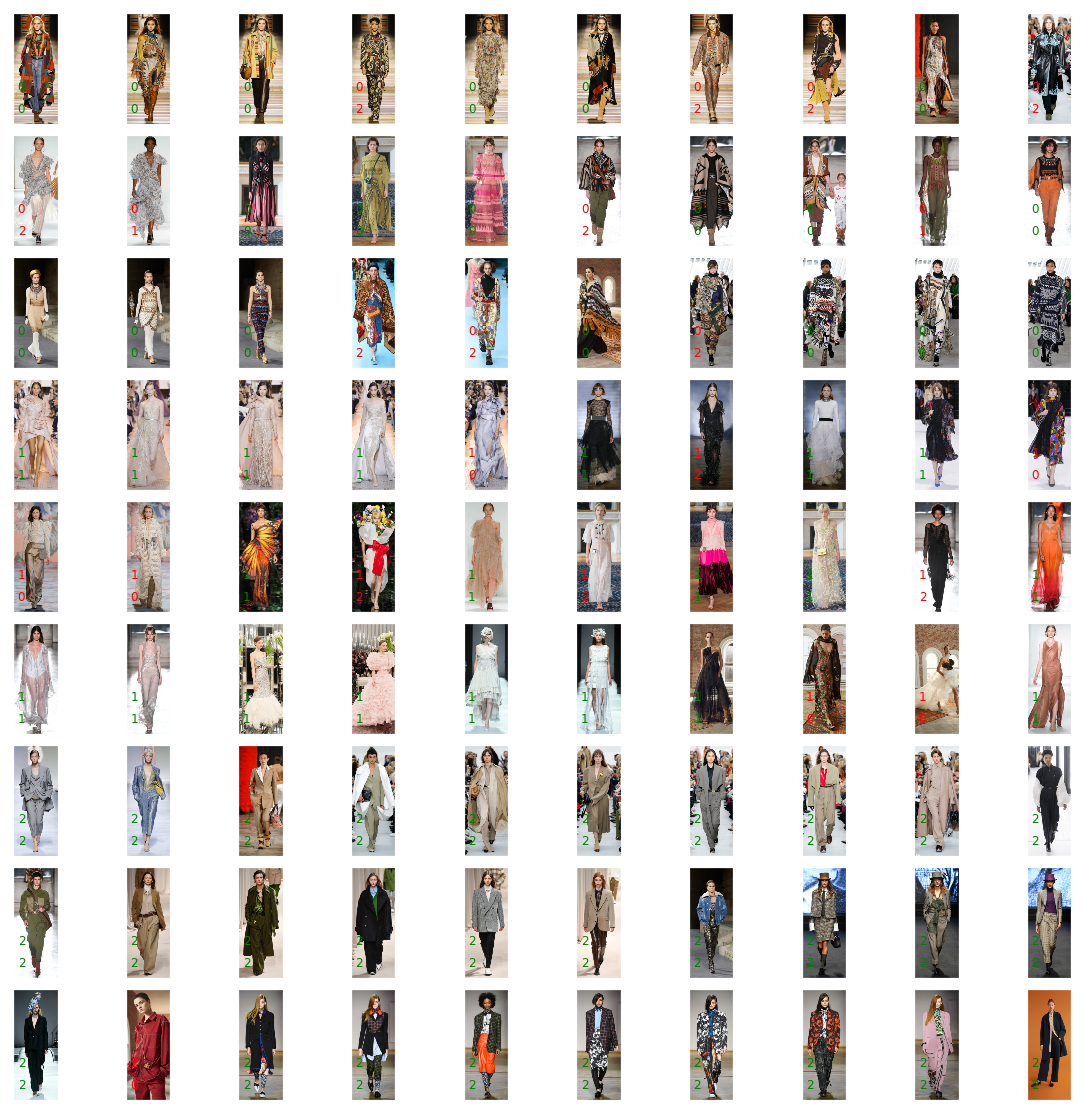

In [ ]:
fig,axes=plt.subplots(9,10,
                      figsize=(20,20),
                      subplot_kw ={'xticks':[],'yticks':[]}, 
                      gridspec_kw = dict(hspace =0.1, wspace = 0.1)
                     )
for i, ax in enumerate(axes.flat):
    ax.imshow(x_test[i],cmap = 'binary', interpolation = 'nearest')
    ax.text(0.1, 0.3, str(y_real_test[i]),
        transform = ax.transAxes,
        color = 'green' if (y_predict_test[i] == y_real_test[i]) else 'red')
    
    ax.text(0.1, 0.1, str(y_predict_test[i]),
        transform = ax.transAxes,
        color = 'green' if (y_predict_test[i] == y_real_test[i]) else 'red')
plt.show()

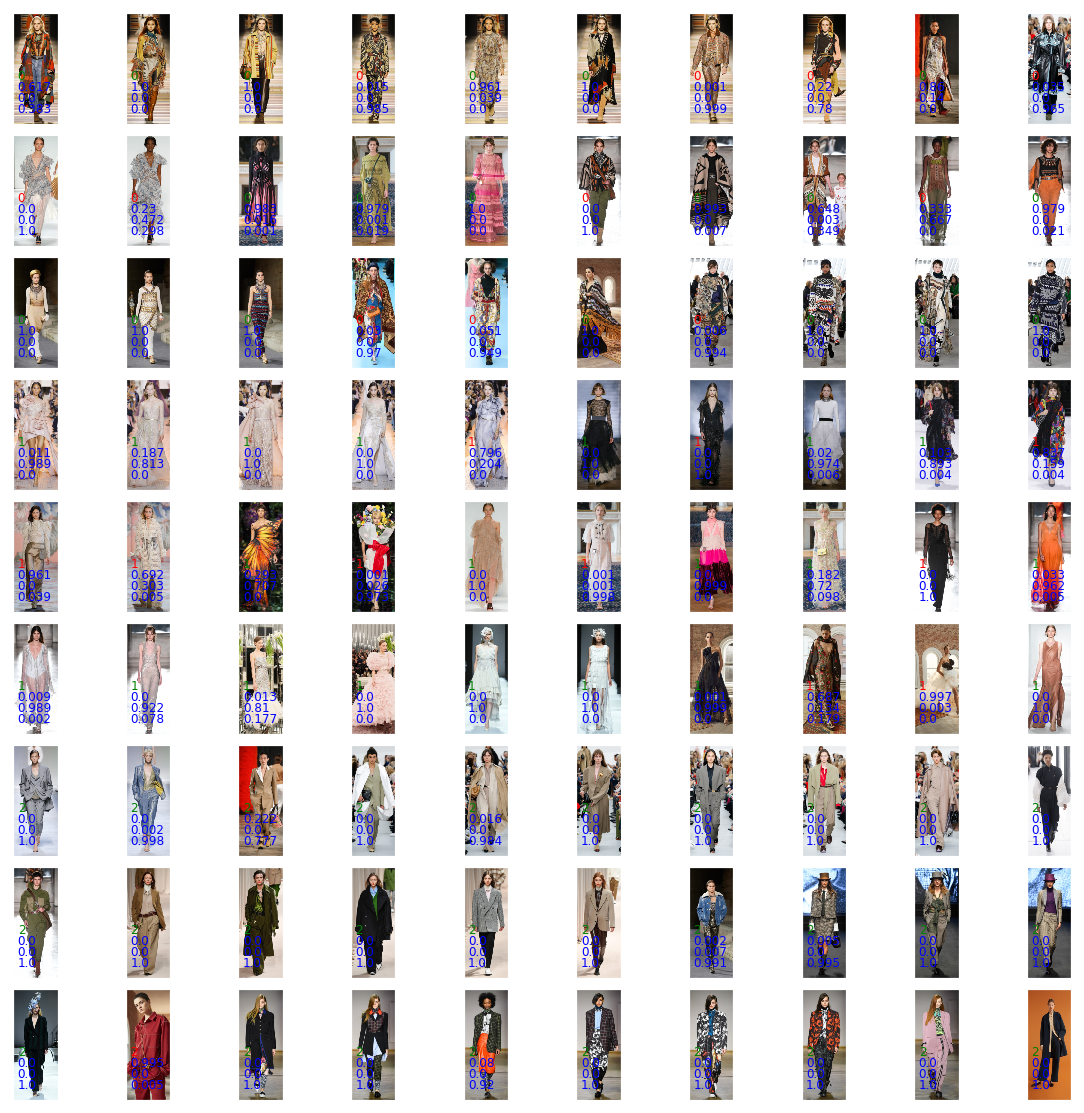

In [ ]:
fig,axes=plt.subplots(9,10,
                      figsize=(20,20),
                      subplot_kw ={'xticks':[],'yticks':[]}, 
                      gridspec_kw = dict(hspace =0.1, wspace = 0.1)
                     )
np.set_printoptions(precision=2)
for i,ax in enumerate(axes.flat):
    ax.imshow(x_test[i],cmap = 'binary', interpolation = 'nearest')
    ax.text(0.1, 0.4, str(y_real_test[i],),
        transform = ax.transAxes, #color = 'blue'
        color = 'green' if (y_predict_test[i] == y_real_test[i]) else 'red'
           )
    
    ax.text(0.1, 0.3, str(np.round(y_predict_test_prob[i,0],3),),
        transform = ax.transAxes,color = 'blue'
        #color = 'green' if (y_predict_test[i] == y_real_test[i]) else 'red'
           )
        
    ax.text(0.1, 0.2, str(np.round(y_predict_test_prob[i,1],3),),
        transform = ax.transAxes,color = 'blue'
        #color = 'green' if (y_predict_test[i] == y_real_test[i]) else 'red'
           )
    
    ax.text(0.1, 0.1, str(np.round(y_predict_test_prob[i,2],3),),
        transform = ax.transAxes,color = 'blue'
        #color = 'green' if (y_predict_test[i] == y_real_test[i]) else 'red'
           )


In [ ]:
classification_report(y_true=y_real_test, y_pred=y_predict_test,labels=[0,1,2])

'             precision    recall  f1-score   support\n\n          0       0.73      0.63      0.68        30\n          1       0.91      0.67      0.77        30\n          2       0.69      0.97      0.81        30\n\navg / total       0.78      0.76      0.75        90\n'

In [ ]:
y_predict_train_prob=new_model.predict(x_train)
y_predict_train=np.argmax(y_predict_train_prob,axis=1)
y_real_train=np.argmax(y_train,axis=1)


Text(89.18,0.5,'true fashion style')

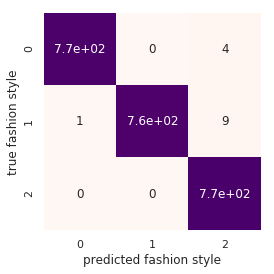

In [ ]:
mat_train = confusion_matrix(y_true=y_real_train, y_pred=y_predict_train,labels=[0,1,2])
sns.heatmap(mat_train, square = True, annot = True, cbar = False, cmap = 'RdPu')
plt.xlabel ('predicted fashion style')
plt.ylabel ('true fashion style')


In [ ]:
classification_report(y_true=y_real_train, y_pred=y_predict_train,labels=[0,1,2])

'             precision    recall  f1-score   support\n\n          0       1.00      0.99      1.00       770\n          1       1.00      0.99      0.99       770\n          2       0.98      1.00      0.99       770\n\navg / total       0.99      0.99      0.99      2310\n'

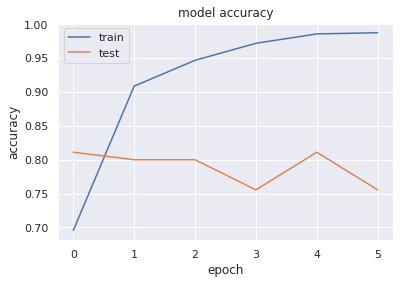

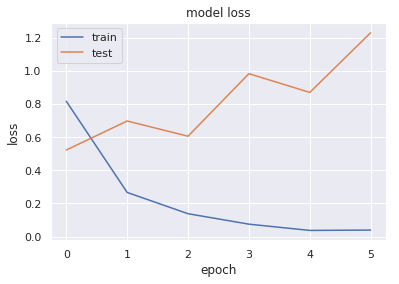

In [ ]:
#Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()